In [2]:
# Need to pip install matplotlib, pandass
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
# Change root directory
dirPath = r'C:\Users\Andreas\Desktop\Thesis\Data'
os.chdir(dirPath)
print('Current working directory: {0}'.format(os.getcwd()))

Current working directory: C:\Users\Andreas\Desktop\Thesis\Data


In [4]:
def unify_csv(dirPath=dirPath, sample = 'all', exercise='all'):

    # unify the csv files from the two apps - with and without video
    # AI Toolbox app - Timestamp (s), gyrX (deg), gyrY (deg), gyrZ (deg)
    # Aries app - SensorName,AppReceiveTime_ms,SensorRecordingTime_ms,DataType,x,y,z

    # Target format:
    # Subject, Exercise, SensorName, DataType, t, x, y, z
    root = dirPath+'\\'+'Raw'
    for samplefolder in os.listdir(root):
        if sample in samplefolder or sample == 'all':

            for exercisefolder in os.listdir(root+'\\'+samplefolder):
                if exercise in exercisefolder or exercise == 'all':
                    
                    for file in os.listdir(root+'\\'+samplefolder+'\\'+exercisefolder):

                        if '.csv' in file:
                            csv_path = root+'\\'+samplefolder+'\\'+exercisefolder+'\\'+file
                            data = pd.read_csv(csv_path, delimiter=',', encoding = 'utf-8')

                            if len(data) > 0:
                                if 'SensorRecordingTime_ms' in data.columns:
                                    # Insert missing columns
                                    data.insert(0,'Subject', samplefolder)
                                    data.insert(1,'Exercise', exercisefolder)
                                    data.insert(6,'t', data['SensorRecordingTime_ms'])
                                    data.drop(columns=['SensorRecordingTime_ms', 'AppReceiveTime_ms'], inplace=True)
                                    # Transform unix time to recording time
                                    t = []
                                    for value in data.t:
                                        t.append((value-data.t[0])/1000)
                                    data['t'] = t

                                    if 'Chest' in data.SensorName[0]:
                                        data['SensorName'] = 'Lumbar'

                                elif 'Timestamp (s)' in data.columns:
                                    # Change column names
                                    data.columns = ('t', 'x', 'y', 'z')
                                    # Insert missing columns
                                    data.insert(0,'Subject',samplefolder)
                                    data.insert(1,'Exercise', exercisefolder)
                                    data.insert(2,'SensorName','video')

                                    if 'accelerometer' in file:
                                        data.insert(3,'DataType','Acc')
                                    elif 'gyroscope' in file:
                                        data.insert(3,'DataType','Gyro')

                                new_root = dirPath+'\\'+'Unified'+'\\'+samplefolder+'\\'+exercisefolder
                                if not os.path.exists(new_root):
                                    os.makedirs(new_root)

                                data.to_csv(new_root+'\\'+file, sep=',', index=False)

In [5]:
unify_csv(sample='12')

In [6]:
def read_csv(dirPath = dirPath, sample = 'all', exercise = 'all'):
    root = dirPath+'\\'+'Unified'
    df = pd.DataFrame()

    for samplefolder in os.listdir(root):
        if sample in samplefolder or sample == 'all':

            for exercisefolder in os.listdir(root+'\\'+samplefolder):
                if exercise in exercisefolder or exercise == 'all':
                    
                    for file in os.listdir(root+'\\'+samplefolder+'\\'+exercisefolder):
                        if '.csv' in file:
                            csv_path = root+'\\'+samplefolder+'\\'+exercisefolder+'\\'+file
                            data = pd.read_csv(csv_path, delimiter=',', encoding = 'utf-8')
                            df = pd.concat([df, data], ignore_index=True)
    return df

In [7]:
df = read_csv(sample='12')

Subject_12-Bridges


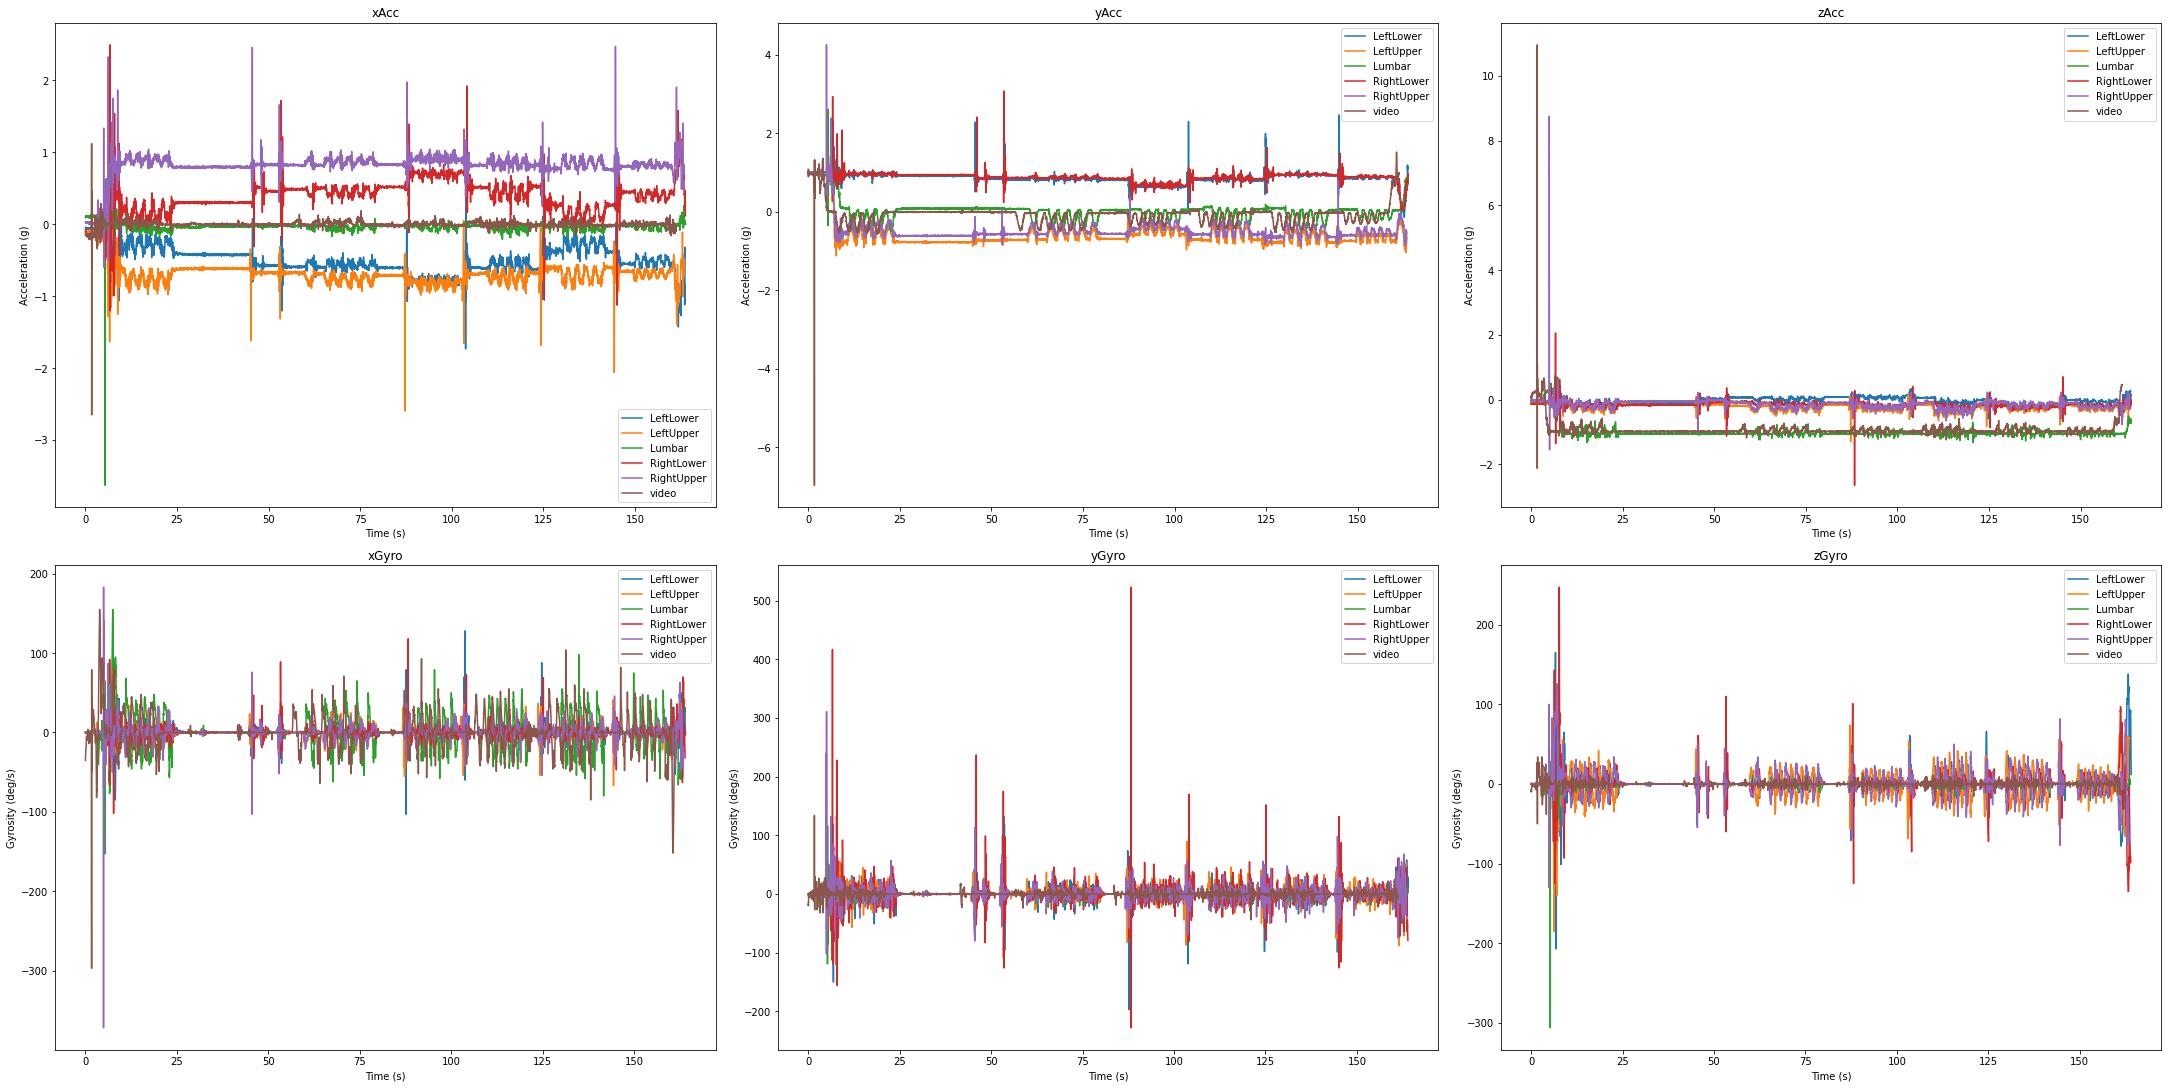

Subject_12-Lunges


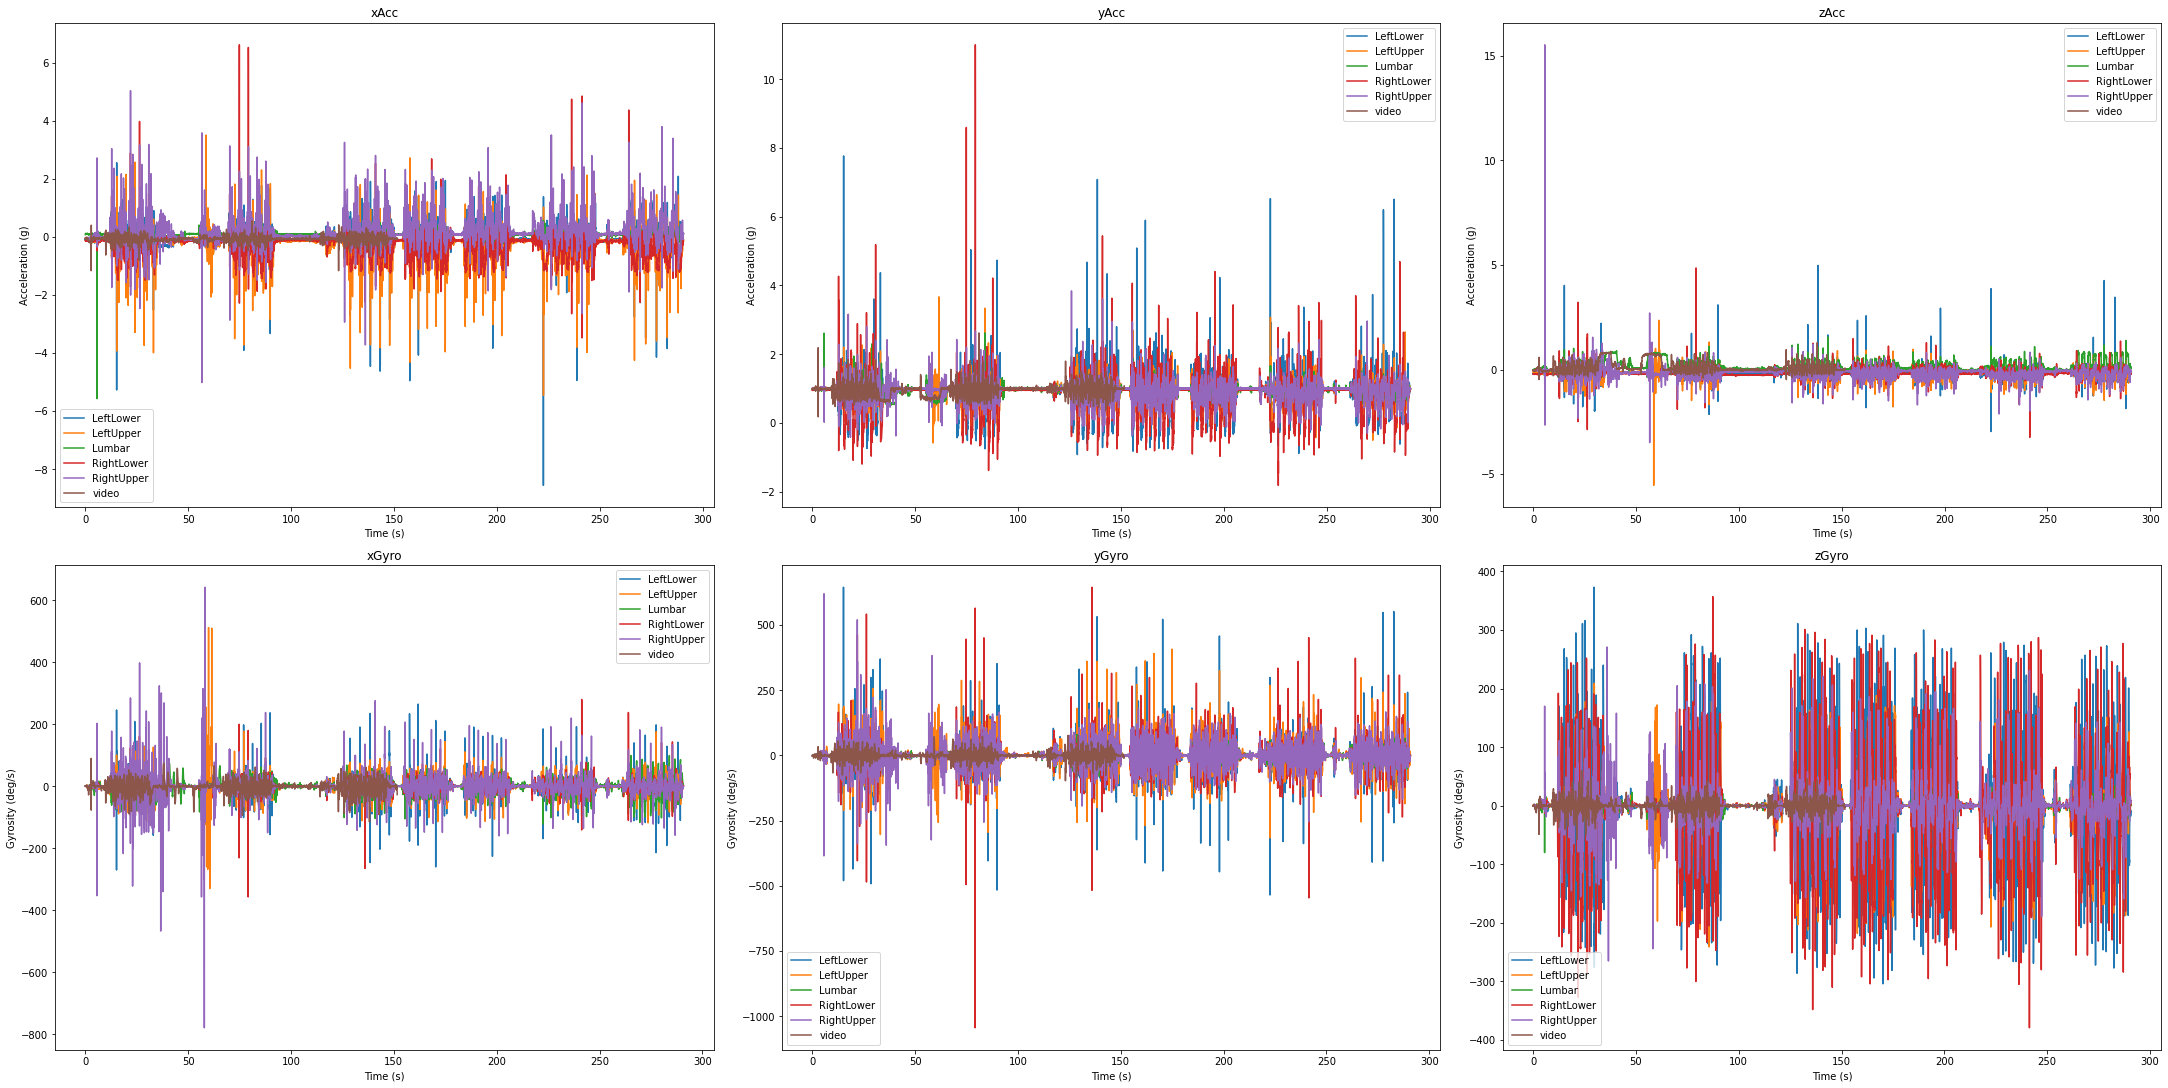

Subject_12-Squats


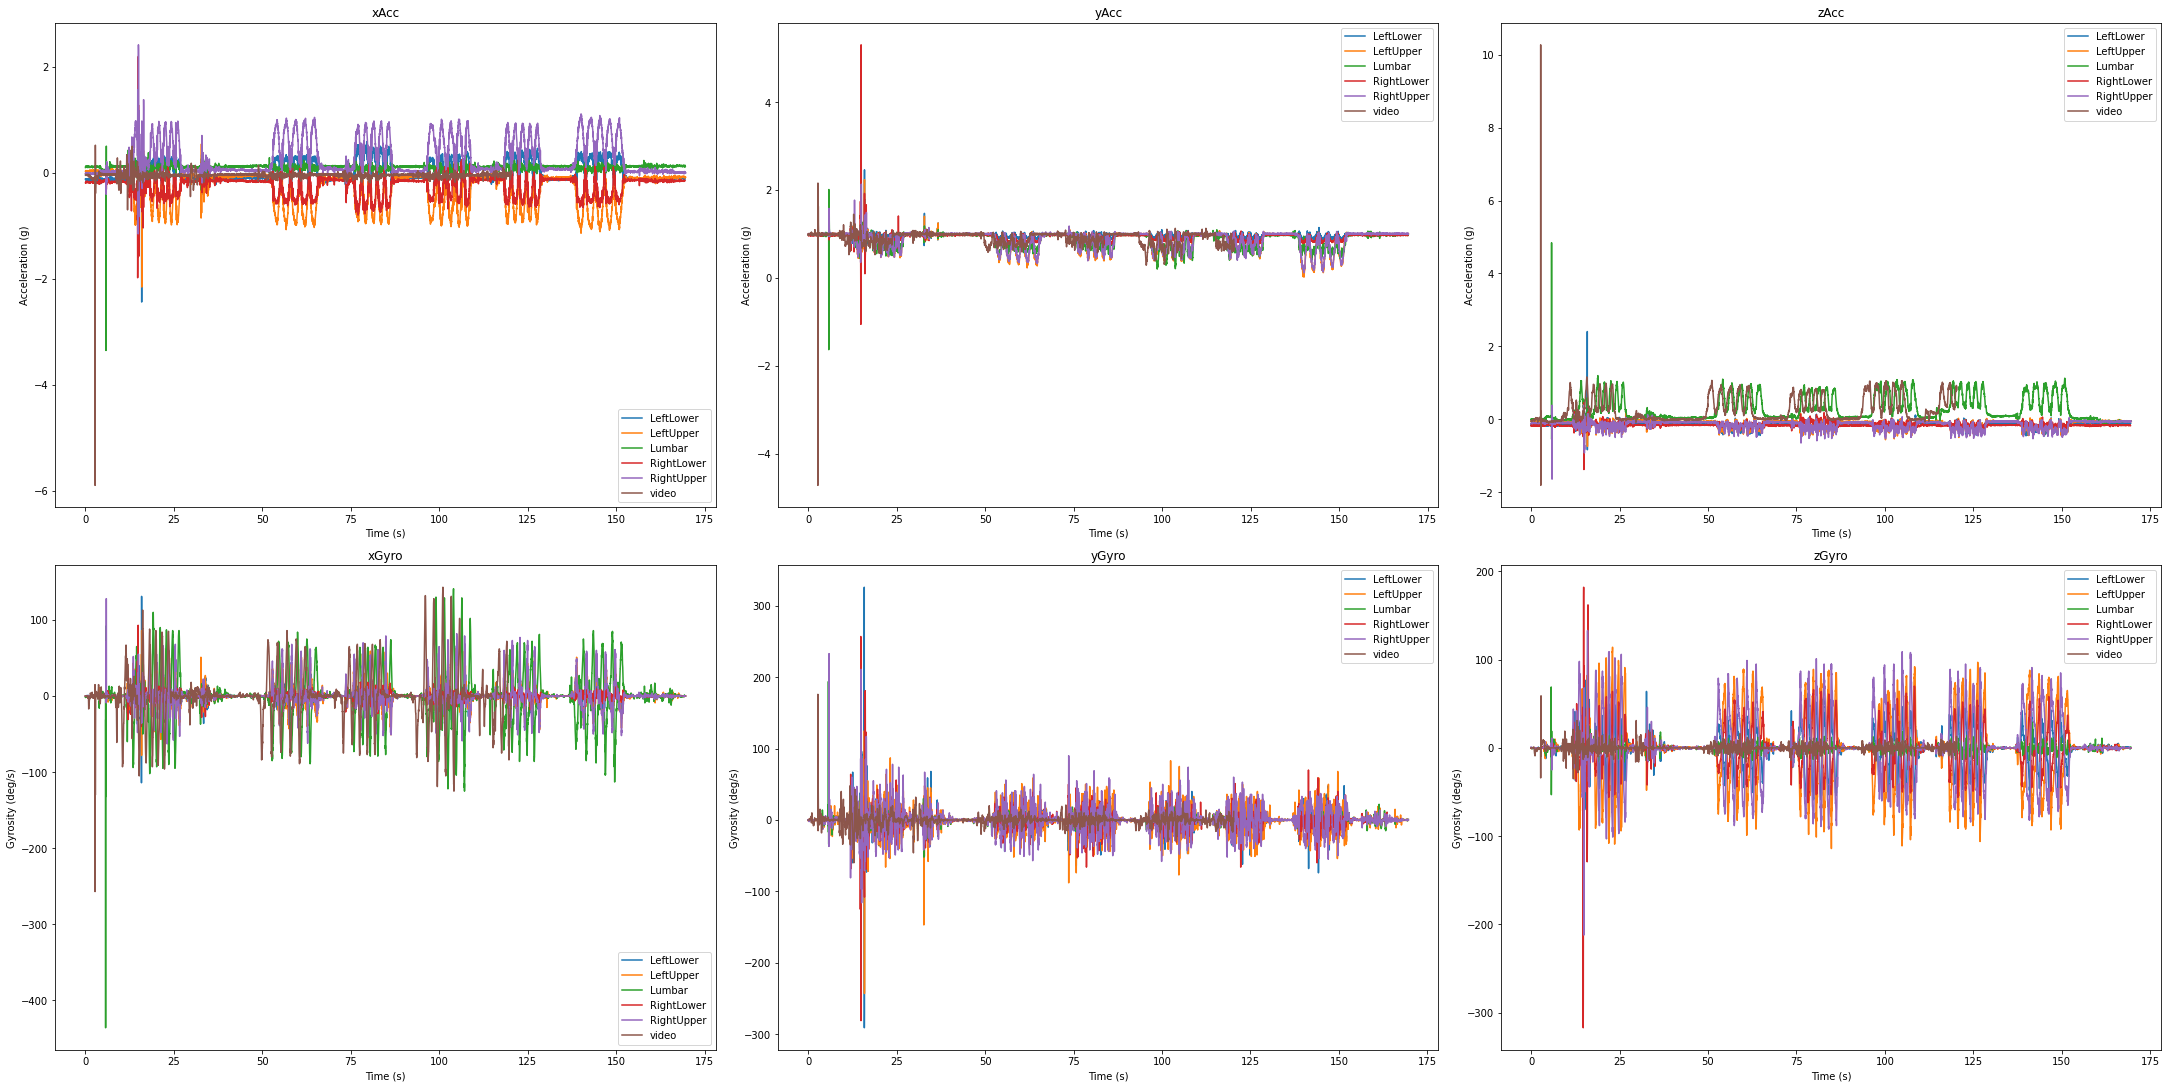

In [8]:
# Plot
subject_groups = df.groupby('Subject')
for strSubject,dfSubject in subject_groups:

    exercise_groups = dfSubject.groupby('Exercise')
    for strExercise, dfExercise in exercise_groups:

        print(strSubject+'-'+strExercise)
        fig, ax = plt.subplots(nrows=2, ncols=3, layout="constrained", figsize=(30,15))

        datatype_groups = dfExercise.groupby('DataType')
        for strDatatype,dfDatatype in datatype_groups:
                       
                sensor_groups = dfDatatype.groupby('SensorName')
                for strSensorName,dfSensorName in sensor_groups:
                        for j,axis in enumerate(['x','y','z']):
                            if strDatatype == 'Acc':
                                i=0
                                ax[i][j].plot(dfSensorName.t, dfSensorName[axis], label = strSensorName)
                                ax[i][j].set_xlabel("Time (s)")
                                ax[i][j].set_ylabel("Acceleration (g)")

                            elif strDatatype == 'Gyro':
                                i=1
                                ax[i][j].plot(dfSensorName.t, dfSensorName[axis], label = strSensorName)
                                ax[i][j].set_xlabel("Time (s)")
                                ax[i][j].set_ylabel("Gyrosity (deg/s)")

                            ax[i][j].set_title(axis+strDatatype)
                            ax[i][j].legend()
        
        plt.show()